In [79]:
import timm
import torch
from tqdm import tqdm
import os
import gc

import wandb

import pandas as pd
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
MODEL_PATH = '/upstage-cv-classification-cv2/results/best_model.pth'
MODEL_NAME = 'efficientnet_b4'

VALID_CSV_PATH = '/upstage-cv-classification-cv2/data/valid.csv'
VALID_IMAGE_PATH = '/upstage-cv-classification-cv2/data/valid'

TEST_CSV_PATH = '/upstage-cv-classification-cv2/data/sample_submission.csv'
TEST_IMAGE_PATH = '/upstage-cv-classification-cv2/data/test'

PROJECT_NAME = 'PatchModel_analyze'

META_CSV_PATH = '/upstage-cv-classification-cv2/data/meta.csv'

In [85]:
meta = pd.read_csv(META_CSV_PATH)

translations = {
        'account_number': '계좌번호',
        'application_for_payment_of_pregnancy_medical_expenses': '건강보험 임신출산 진료비 지급 신청서',
        'car_dashboard': '자동차 계기판',
        'confirmation_of_admission_and_discharge': '입퇴원 확인서',
        'diagnosis': '진단서',
        'driver_lisence': '운전면허증',
        'medical_bill_receipts': '진료비영수증',
        'medical_outpatient_certificate': '통원진료 확인서',
        'national_id_card': '주민등록증',
        'passport': '여권',
        'payment_confirmation': '진료비 납입 확인서',
        'pharmaceutical_receipt': '약제비 영수증',
        'prescription': '처방전',
        'resume': '이력서',
        'statement_of_opinion': '소견서',
        'vehicle_registration_certificate': '자동차 등록증',
        'vehicle_registration_plate': '자동차 번호판'
}

meta['kr_class_name'] = meta['class_name'].map(lambda x : translations[x])
meta

,target,class_name,kr_class_name
0,0,account_number,계좌번호
1,1,application_for_payment_of_pregnancy_medical_e...,건강보험 임신출산 진료비 지급 신청서
2,2,car_dashboard,자동차 계기판
3,3,confirmation_of_admission_and_discharge,입퇴원 확인서
4,4,diagnosis,진단서
5,5,driver_lisence,운전면허증
6,6,medical_bill_receipts,진료비영수증
7,7,medical_outpatient_certificate,통원진료 확인서
8,8,national_id_card,주민등록증
9,9,passport,여권


# 모델 로드

In [86]:
torch.cuda.empty_cache()
gc.collect()

2189

In [87]:
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=17).to(device)

# 모델 가중치 로드
model.load_state_dict(torch.load(MODEL_PATH))

/tmp/ipykernel_418792/2802445694.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

# 모델 성능 확인

In [88]:
# training config
img_size = 380
LR = 1e-3
BATCH_SIZE = 32

patience = 5
min_delta = 0.001 # 성능 개선의 최소 변화량

# test image 변환
data_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2()
])

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image = img)['image']
    
        return img, target, name

    def get_labels(self):
        return self.df[:, 1] 

In [89]:
val_dataset = ImageDataset(
    VALID_CSV_PATH,
    VALID_IMAGE_PATH,
    transform = data_transform
)

test_dataset = ImageDataset(
    TEST_CSV_PATH,
    TEST_IMAGE_PATH,
    transform = data_transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

In [90]:
valid_preds_list = []
valid_targets_list = []
valid_ids = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(val_loader)
    for step, (image, targets, id) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        preds = model(image)
        loss = loss_fn(preds, targets)
    
        valid_preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        valid_targets_list.extend(targets.detach().cpu().numpy())
        valid_ids.extend(id)

        pbar.set_description(f"Loss: {loss.item():.4f}")



Loss: 0.0158: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


In [91]:
test_preds_list = []
test_ids = []
test_probs_list = []
test_preds_second_list = []
test_probs_second_list = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(test_loader)
    for step, (image, targets, id) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        outputs = model(image)
        loss = loss_fn(outputs, targets)

        probs = torch.softmax(outputs, dim=1)
        
        # 최댓값과 두 번째로 큰 값 가져오기
        top_probs, top_indices = torch.topk(probs, 2, dim=1)
        
        # 최댓 확률값과 예측 클래스 인덱스
        max_probs = top_probs[:, 0]
        preds = top_indices[:, 0]
        
        # 두 번째로 큰 확률값과 클래스 인덱스
        second_probs = top_probs[:, 1]
        second_preds = top_indices[:, 1]

        # 제일 확률 높은 데이터
        test_preds_list.extend(preds.detach().cpu().numpy()) 
        test_probs_list.extend(max_probs.detach().cpu().numpy())

        # 두번째 확률 높은 데이터  
        test_preds_second_list.extend(second_preds.detach().cpu().numpy())
        test_probs_second_list.extend(second_probs.detach().cpu().numpy())

        test_ids.extend(id)

        pbar.set_description(f"Loss: {loss.item():.4f}")



Loss: 13.8069: 100%|██████████| 99/99 [00:15<00:00,  6.42it/s]


In [92]:
valid_result_df = pd.DataFrame()
valid_result_df['id'] = valid_ids
valid_result_df['pred'] = valid_preds_list
valid_result_df['target'] = valid_targets_list

valid_result_df['pred_kr'] = valid_result_df['pred'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])
valid_result_df['target_kr'] = valid_result_df['target'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])

valid_result_df

,id,pred,target,pred_kr,target_kr
0,valid_d919dabe9f066dfc.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
1,valid_7f23b9ae37e539ea.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
2,valid_9a36a151cf95bb29.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
3,valid_f0d11155d48758de.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
4,valid_c8816965abf6559b.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
...,...,...,...,...,...
291,valid_1421fb31607c5123.jpg,13,13,이력서,이력서
292,valid_70ee60fe819b7b39.jpg,0,0,계좌번호,계좌번호
293,valid_359fab2e1b0ab5e1.jpg,2,2,자동차 계기판,자동차 계기판
294,valid_01385f22f2490868.jpg,4,4,진단서,진단서


In [95]:
test_result_df = pd.DataFrame()
test_result_df['id'] = test_ids
test_result_df['first_pred'] = test_preds_list
test_result_df['first_prob'] = test_probs_list
test_result_df['second_pred'] = test_preds_second_list
test_result_df['second_prob'] = test_probs_second_list

test_result_df['first_pred_kr'] = test_result_df['first_pred'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])
test_result_df['second_pred_kr'] = test_result_df['second_pred'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])

test_result_df

,id,first_pred,first_prob,second_pred,second_prob,first_pred_kr,second_pred_kr
0,0008fdb22ddce0ce.jpg,2,1.000000,12,5.293225e-11,자동차 계기판,처방전
1,00091bffdffd83de.jpg,12,1.000000,6,3.877882e-08,처방전,진료비영수증
2,00396fbc1f6cc21d.jpg,5,1.000000,12,1.668210e-11,운전면허증,처방전
3,00471f8038d9c4b6.jpg,4,0.816450,12,8.639906e-02,진단서,처방전
4,00901f504008d884.jpg,2,1.000000,1,7.791749e-13,자동차 계기판,건강보험 임신출산 진료비 지급 신청서
...,...,...,...,...,...,...,...
3135,ffb4b6f619fb60ea.jpg,6,0.999964,10,2.279942e-05,진료비영수증,진료비 납입 확인서
3136,ffb54299b1ad4159.jpg,10,0.968894,11,2.595469e-02,진료비 납입 확인서,약제비 영수증
3137,ffc2c91dff8cf2c0.jpg,8,1.000000,0,4.640368e-08,주민등록증,계좌번호
3138,ffc4e330a5353a2a.jpg,0,1.000000,11,6.265063e-13,계좌번호,약제비 영수증


<Axes: xlabel='second_pred', ylabel='first_pred'>

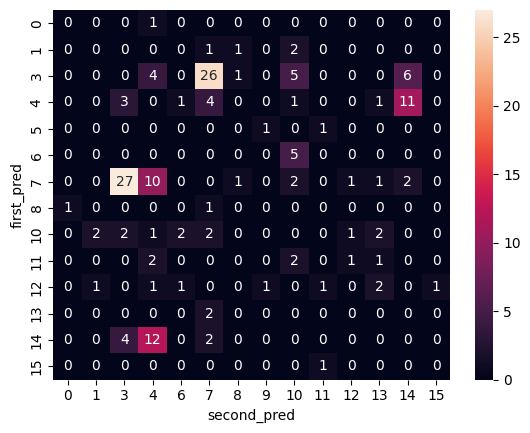

In [100]:
temp_df = test_result_df[(test_result_df['first_prob'] < 0.8)].sort_values(by='first_prob')

crosstab = pd.crosstab(temp_df['first_pred'], temp_df['second_pred'])

sns.heatmap(data = crosstab, annot=True)

In [ ]:
print("Classification Report:")
report = classification_report(valid_targets_list, valid_preds_list, target_names=[str(i) for i in range(17)])
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        20
           3       0.64      0.58      0.61        12
           4       0.73      0.94      0.82        17
           5       0.89      1.00      0.94        16
           6       1.00      0.90      0.95        29
           7       0.80      0.60      0.69        20
           8       0.94      0.94      0.94        16
           9       1.00      1.00      1.00        12
          10       0.80      1.00      0.89        20
          11       1.00      0.85      0.92        13
          12       0.95      0.91      0.93        22
          13       1.00      0.94      0.97        17
          14       0.93      0.93      0.93        14
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        16

   

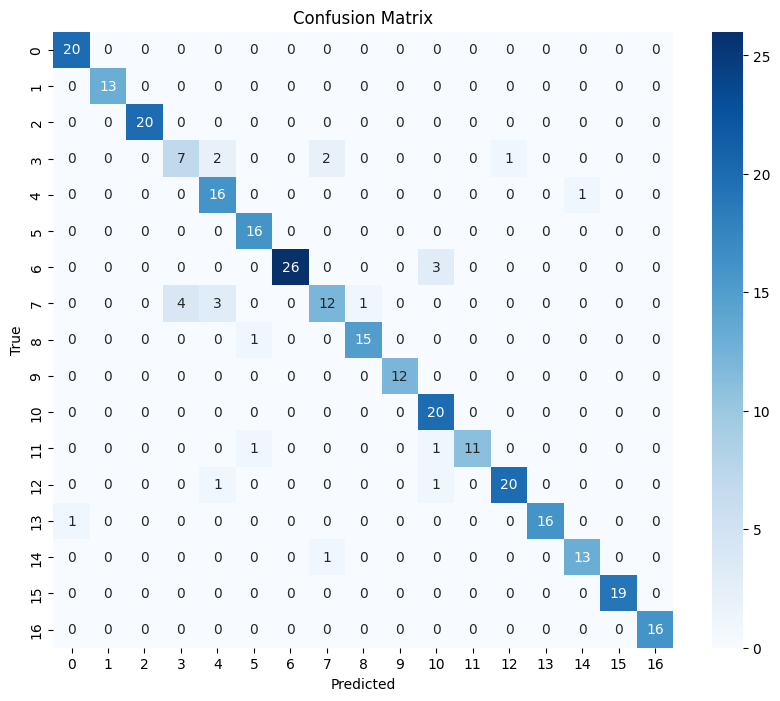

In [ ]:
cm = confusion_matrix(valid_targets_list, valid_preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
plt.close()

# wandb 시각화

In [48]:
wandb.init(project=PROJECT_NAME)

wandb: Network error resolved after 0:00:08.273370, resuming normal operation.
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request


In [49]:
wandb_images = {"wrong" : [],
                "target 00" : [],
                "target 01" : [],
                "target 02" : [],
                "target 03" : [],
                "target 04" : [],
                "target 05" : [],
                "target 06" : [],
                "target 07" : [],
                "target 08" : [],
                "target 09" : [],
                "target 10" : [],
                "target 11" : [],
                "target 12" : [],
                "target 13" : [],
                "target 14" : [],
                "target 15" : [],
                "target 16" : [],}

for id, pred, target, pred_kr, target_kr in valid_result_df.itertuples(index=False):
    image_np = np.array(Image.open(os.path.join(VALID_IMAGE_PATH, id)).resize((224, 224), Image.LANCZOS))
    image = wandb.Image(image_np, caption=f"실제 : {target_kr}({target})\n예측 : {pred_kr}({pred})")

    wandb_images[f"target {target:02}"].append(image)
    
    if target != pred:
        wandb_images["wrong"].append(image)

wandb.log(wandb_images)

In [75]:
wandb.init(project=PROJECT_NAME, name='test dataset')
"""
wandb_images = {"test 00" : [],
                "test 01" : [],
                "test 02" : [],
                "test 03" : [],
                "test 04" : [],
                "test 05" : [],
                "test 06" : [],
                "test 07" : [],
                "test 08" : [],
                "test 09" : [],
                "test 10" : [],
                "test 11" : [],
                "test 12" : [],
                "test 13" : [],
                "test 14" : [],
                "test 15" : [],
                "test 16" : [],
                "test prob 0.8" : []}
"""

wandb_images = {"test prob 0.8" : []}

for id, pred, prob, pred_kr in test_result_df.itertuples(index=False):
    image_np = np.array(Image.open(os.path.join(TEST_IMAGE_PATH, id)).resize((224, 224), Image.LANCZOS))
    image = wandb.Image(image_np, caption=f"예측 : {pred_kr}({pred}) 확신 : {prob}")

    #if len(wandb_images[f"test {pred:02}"]) < 108:
    #    wandb_images[f"test {pred:02}"].append(image)

    if prob < 0.8:
        wandb_images['test prob 0.8'].append(image)

wandb.log(wandb_images)

In [52]:
test_result_df.to_csv("/upstage-cv-classification-cv2/data/patch_model_pred_result.csv", index=False)